## Prepare data for testing against 2 models

Take X and y data and apply 10-fold cross validation. Save 8 folds as training, 1 as validation, and 1 as testing.
Save all this in an HDF5 files (separated by class) for testing on NADE.
Save the training/validation folds as training data and testing fold as testing data for KDE model.


HDF5 Hierarhcy (same as Wine dataset)
- all
- folds
    - 1
        - tests
            - 1
        - training
            - 1
            - 2
            - ...
            - 8
            - 9
    - 2
    - ...
    - 9


Usage:
- Use folds/1/training/ 1 - 8 as training
- Use folds/1/training/9 as validation
- Use folds/1/testing/1 as testing


HDF5 Background:
Groups are the container mechanism by which HDF5 files are organized. From a Python perspective, they operate somewhat like dictionaries. In this case the “keys” are the names of group members, and the “values” are the members themselves (Group and Dataset) objects.

From here https://docs.h5py.org/en/stable/high/group.html

Pandas has a method HDFStore, but I found it would not work well. It was making 4 members for each DataFrame. so I used h5py directly

the following works, at least it has the same members and structure as wine dataset

In [6]:
import os
import pandas as pd
import numpy as np
import h5py
from sklearn.model_selection import KFold
from collections import OrderedDict 
test_path = "/Users/marina/Documents/PhD/research/astro_research/data/testing/"
dpath = test_path + "PROCESSED_DATA/"

def prettify(class_name):
    if "/" in class_name:
        class_name=class_name.replace("/", "")
    class_name=class_name.replace(" ", "_")
    return class_name

def save_HDF5s(training_folds, val_fold, test_fold, thex_data_path):
    """
    Save class data to HDF5
    """
    # Save to HDF5 File  
    hfile = h5py.File(thex_data_path, 'w')
    # define & fill groups
    for i in range(8):
        training = hfile.create_group("folds/1/training/" + str(i+1))
        data = training_folds[i].to_numpy(dtype=np.float32)
        dset = training.create_dataset("data", data=data)
    val = hfile.create_group("folds/1/training/9")
    dset = val.create_dataset("data", data=val_fold.to_numpy(dtype=np.float32))
    val = hfile.create_group("folds/1/tests/1")
    dset = val.create_dataset("data", data=test_fold.to_numpy(dtype=np.float32))
    hfile.close()
    

def save_CSVs(fold_sets, class_X, class_name, output_dir):
    """
    Save class data to CSV
    """
    train_indices = []
    for i in range(9): # Include validation fold in training
        train_indices += fold_sets[i].tolist() 
    class_train = class_X.iloc[train_indices]
    class_test = class_X.iloc[fold_sets[9]]
    class_train.to_csv(output_dir + prettify(class_name) + "train.csv", index=False)
    class_test.to_csv(output_dir + prettify(class_name) + "test.csv", index=False)

def save_class_data(class_name, X, y, output_dir):
    """
    Save the X data of this class as HDF5 file
    Returns test fold to be saved separately in joined test file.
    """ 
    label_name = list(y)[0]
    class_indices = y.loc[y[label_name].str.contains(class_name)].index
    class_X = X.iloc[class_indices]

    # Divide data into 10 folds; use 8 as training, 1 as validation, 1 as testing
    kf = KFold(n_splits=10, shuffle=True)
    fold_sets = []
    for remaining_indices, fold_indices in kf.split(class_X):
        fold_sets.append(fold_indices)
    training_folds=[]
    for i in range(8):
        training_folds.append(class_X.iloc[fold_sets[i]])

    val_fold = class_X.iloc[fold_sets[8]]
    test_fold = class_X.iloc[fold_sets[9]]
    
    # Save to HDF5 File 
    class_path = output_dir + prettify(class_name) + 'X.hdf5'
    save_HDF5s(training_folds, val_fold, test_fold, class_path)
    
    # Also save as CSVs - to test on KDE Model
    save_CSVs(fold_sets, class_X, class_name, output_dir)
    
    return test_fold

 
def save_test_X_y(test_folds, dpath):
    """
    Using existing folds, combine each class's test fold into one whole test data set.
    Save as both an HDF5 and CSV. 
    """
    full_test_set = pd.concat(test_folds.values())
    hfile = h5py.File(dpath + "test_X.hdf5", 'w')
    group = hfile.create_group("folds/1/tests/1")
    dset = group.create_dataset("data", data=full_test_set.to_numpy(dtype=np.float32))
    hfile.close()
    # Save as CSV too for KDE model testing
    full_test_set.to_csv(dpath + "test_X.csv", index=False)

    # Save labels corresponding to test set in CSV.
    labels = []
    for class_name in test_folds.keys():
        class_count = test_folds[class_name].shape[0]
        for i in range(class_count):
            labels.append(class_name)
    
    label_df = pd.DataFrame(labels, columns=["transient_type"])
    label_df.to_csv(dpath+"test_y.csv",index=False)

def save_train_X_y(dpath, classes):
    """
    Load train X CSV files, and combine all into one X training file
    Save labels in correct order in corresponding y file.
    For use in KDE model.
    """
    class_dfs = []
    labels = []
    for class_name in classes:
        class_X = pd.read_csv(dpath + prettify(class_name) + "train.csv")
        class_dfs.append(class_X)
        for i in range(class_X.shape[0]):
            labels.append(class_name)
    X = pd.concat(class_dfs)
    X.to_csv(dpath + "train_X.csv", index=False)
    y = pd.DataFrame(labels, columns=['transient_type'])
    y.to_csv(dpath + "train_y.csv", index=False)



## THEx Data
Load and prep THEx data for testing

In [64]:
# CONSTS
# classes = ['Unspecified Ia', 'Unspecified Ia Pec', 'Ia-91T', 'Ia-91bg', 'Ib/c', 'Unspecified Ib', 'IIb', 
#            'Unspecified Ic', 'Ic Pec', 'Unspecified II', 'II P', 'IIn', 'TDE', 'GRB']
classes = ['Unspecified Ia', 'Unspecified II']

#  Data Note
#  The following data comes from an initialized THEx MultiModel. 
#  So, it represents all rows that have valid values for the mags and colors
X = pd.read_csv(test_path + "X.csv")
y = pd.read_csv(test_path + "y.csv")

# keep mags only because having to normalize the data with 
X_mags_only = X[["g_mag",  "r_mag", "i_mag", "z_mag", "y_mag", "W1_mag", "W2_mag", "J_mag", "K_mag", "H_mag"]]
X_colors_only = X[['g_mag_minus_r_mag', 'i_mag_minus_z_mag', 'H_mag_minus_K_mag', 'y_mag_minus_J_mag', 
                 'r_mag_minus_i_mag', 'K_mag_minus_W1_mag', 'J_mag_minus_H_mag', 'z_mag_minus_y_mag',
                 'W1_mag_minus_W2_mag']]


# Save each class to separate HDF5 file to train on 
test_folds = OrderedDict()
for class_name in classes:
    test_folds[class_name] = save_class_data(class_name, X_colors_only, y, dpath)

save_test_X_y(test_folds, dpath)

save_train_X_y(dpath, classes)

In [51]:
# classes = ['Unspecified Ia', 'Unspecified II']
# class_indices = {}
# for class_name in classes:
#     class_count =0 
#     for index, row in y.iterrows():
#         labels = y.iloc[index]['transient_type']
#         if "Unspecified Ia" in labels: 
#             class_count+=1
#     print(class_count) 


6729
6729


### Synthetic Data
Gaussian distributed features

In [28]:
import numpy as np
import pandas as pd
import random
from collections import OrderedDict

classes = ['dog', 'cat', 'mouse']
features = ['num_legs', 'num_ears', 'color']
class_sizes = [300,300, 300]

class_data = OrderedDict()
true_labels = []
for class_index, class_name in enumerate(classes): 
    class_size = class_sizes[class_index]
    class_features = []
    for i in range(class_size):
        true_labels.append(class_name)
    print("\n\nClass " + str(class_name))
    for feature_index, feature in enumerate(features):
        random_mean=random.randint(1,6)
#         random_mean = random.randint(feature_index,feature_index+3)
        random_stdev = 1 #random.randint(1,2)
        N = class_size
        class_f = np.random.normal(random_mean, random_stdev, N)
        class_features.append(np.atleast_2d(class_f).T)
        print("Mean " + str(random_mean) + " stdev " + str(random_stdev))
    # Clas matrix
    class_m = np.concatenate(class_features, axis=1)
    
    # save as PD DataFrame
    class_df = pd.DataFrame(class_m, columns=features)
    class_data[class_name] = class_df
    
X = pd.concat(class_data.values(), axis=0).reset_index(drop=True)



Class dog
Mean 5 stdev 1
Mean 2 stdev 1
Mean 4 stdev 1


Class cat
Mean 5 stdev 1
Mean 6 stdev 1
Mean 3 stdev 1


Class mouse
Mean 1 stdev 1
Mean 1 stdev 1
Mean 5 stdev 1


In [29]:
# Save labels a y
y = pd.DataFrame(true_labels, columns=['transient_type'])

In [30]:
X.to_csv(test_path + "synthetic_X.csv", index=False)
y.to_csv(test_path + "synthetic_y.csv", index=False)

In [31]:
# Save each class to separate HDF5 file to train on 
test_folds = OrderedDict()
for class_name in classes:
    test_folds[class_name] = save_class_data(class_name, X, y, dpath)

save_test_X_y(test_folds, dpath)

save_train_X_y(dpath, classes)

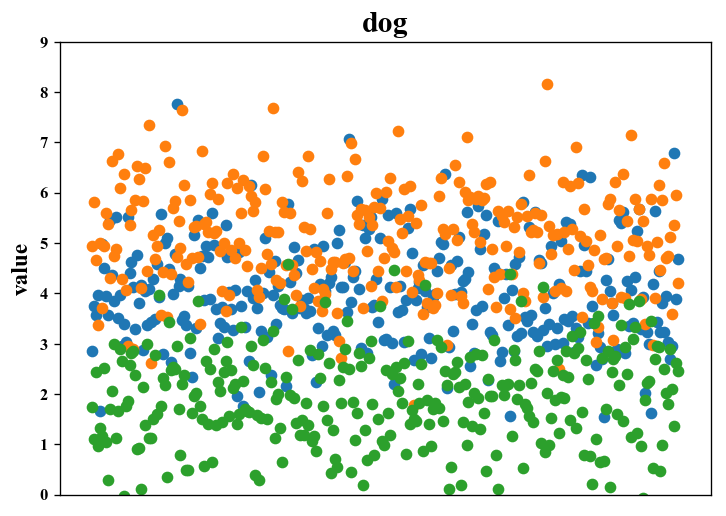

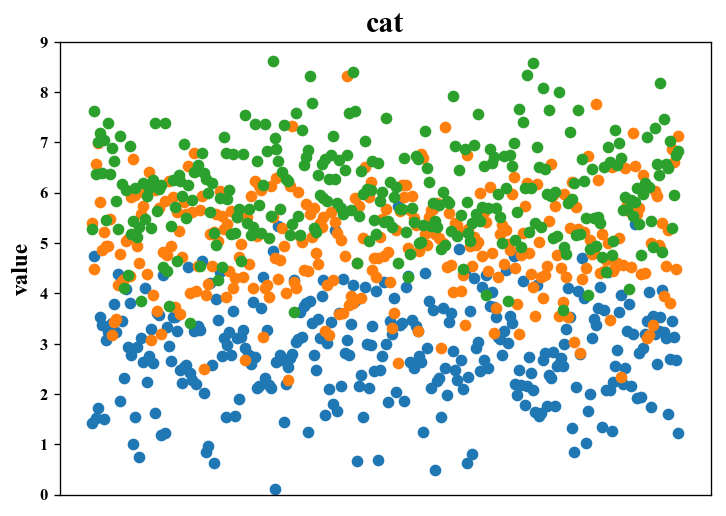

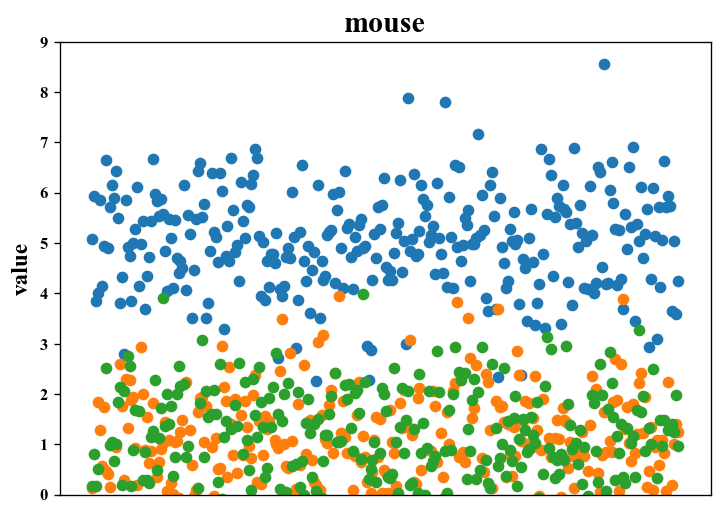

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
for class_index, class_name in enumerate(classes):   
    plt.figure(figsize=(7, 5), dpi=120)
    d = class_data[class_name]['color']
    plt.scatter(np.linspace(0,1,len(d)), d, label = 'color')
    d = class_data[class_name]['num_legs']
    plt.scatter(np.linspace(0,1,len(d)), d, label='num_legs')
    d = class_data[class_name]['num_ears']
    plt.scatter(np.linspace(0,1,len(d)), d, label = 'num_ears')
    plt.ylabel("value", fontsize=14)
    plt.ylim([0, 9])
    plt.xticks([])
    plt.title(class_name, fontsize=18) 
    plt.savefig(test_path + "OUTPUT/data_dist_"+class_name+".pdf", bbox_inches = 'tight')
#     plt.savefig()
# for class_index, class_name in enumerate(classes):  
#     for feature_index, feature in enumerate(features):
#         class_data[class_name][feature]

## Init BigDataset with THEx HDF5 data

In [ ]:
import sys
sys.path
sys.path.append('buml') 
import os
import Data.utils

dpath = "/Users/marina/Documents/PhD/research/astro_research/data/testing/"
thex_data_path = dpath + "Unspecified_IaX.hdf5"

# os.environ["DATASETSPATH"]=""
# data_source = "red_wine.hdf5"
# dataset_file = os.path.join(os.environ["DATASETSPATH"], data_source)
dataset_file = thex_data_path
training_dataset = Data.BigDataset(dataset_file, 
                                   "/folds/1/training/(1|2|3|4|5|6|7|8)", 
                                   "data") 
testing_dataset = Data.BigDataset(dataset_file, "/folds/1/tests/.*", "data")
validation_dataset = Data.BigDataset(dataset_file, "/folds/1/training/9", "data")

In [ ]:
validation_dataset.sample_data(3)

## Wine Dataset Study

Outcomes

1. 159 samples in each training fold
2. 168 in validation 
3. 159 in testing

There is OVERLAP among all 3. So testing data inside of training and validation.
46/159 testing samples in the whole training set
9/159 testing samples in validation 

And overlap in training/validation.

wine dataset HDF5 data has the following hierarchy:
- all
- folds
    - 1
        - tests
            - 1
        - training
            - 1
            - 2
            - ...
            - 8
            - 9
    - 2
    - ...
    - 9

### Examine if there is any data overlap in training/validation/testing

In [ ]:
import sys
sys.path
sys.path.append('buml') 
import os
import Data.utils
os.environ["DATASETSPATH"]=""
data_source = "red_wine.hdf5"
training = "/folds/1/training/(1|2|3|4|5|6|7|8)"
dataset_file = os.path.join(os.environ["DATASETSPATH"], data_source)
training_dataset = Data.BigDataset(dataset_file, training, "data")
testing_dataset = Data.BigDataset(dataset_file, "/folds/1/tests/.*", "data")
validation_dataset = Data.BigDataset(dataset_file, "/folds/1/training/9", "data")

In [ ]:
a=testing_dataset.get_file(0, 0)[1]

In [ ]:
a.shape

In [ ]:
b=a.T
b.shape

In [ ]:
np.atleast_2d(a).T

In [ ]:
# Make sure no testing/training/validation overlaps
training_indices= [0,1,2,3,4,5,6,7]
validation_index = [8]

test_overlap_count = 0
for i in range(testing_fold.shape[0]):
    test_sample = testing_fold[i]
    # No overlap with training/testing
    total_training = 0 #to keep track of later.
    for ti in training_indices:
        training_fold = training_dataset.get_file(element = 0, index= ti)
        for row in training_fold:
            total_training +=1
            if (row == test_sample).all():
                test_overlap_count+=1
print("Overlap in testing and training " + str(test_overlap_count))

In [ ]:
# No overlap with validation/testing
validation_fold = validation_dataset.get_file(element = 0, index= 0)
val_overlap_count = 0
for i in range(testing_fold.shape[0]):
    test_sample = testing_fold[i]
    for row in validation_fold:
        if (row == test_sample).all():
            val_overlap_count+=1
print("Overlap in validation and testing " + str(val_overlap_count))

In [ ]:
# No overlap with training/validation
matching_rows=0
for i in range(validation_fold.shape[0]):
    validation_sample = validation_fold[i]
    for ti in training_indices:
        training_fold = training_dataset.get_file(element = 0, index= ti)
        for row in training_fold:
            if (row == validation_sample).all():
                matching_rows +=1
print("Number of matching rows in validation + training " + str(matching_rows))


In [ ]:
print("Total rows in training " + str(total_training))
print("Total rows in validation " + str(validation_fold.shape[0]))
print("Total rows in testing " + str(testing_fold.shape[0]))

### Manually pulling down wine-dataset and manually examining entries 

In [ ]:
import h5py
wine_f = h5py.File("red_wine.hdf5", "r")
# wine_f["/"]

print(wine_f.name)
print(wine_f.keys)

In [ ]:

element_names="data"
element_names = element_names if isinstance(element_names, tuple) else (element_names,)

# entries_regexp = "/folds/1/training/(1|2|3|4|5|6|7|8)" # Training 
# entries_regexp="/folds/1/tests/.*"  # Testing 
entries_regexp = "/folds/1/training/9"  # Validation 
pats = entries_regexp.split("/")
pats.remove("")

"""
Coming up with entries:

We pass in "/folds/1/training/(1|2|3|4|5|6|7|8)" as the 'entries_regexp' 
so we are saying to use folds 1-8 for training

So, it selects the parts of the HDF5 dataset that are located at the part of the hierarhcy we
are selecting, using the regexp. 

- Use folds/1/training/ 1 - 8 as training
- Use folds/1/training/9 as validation
- Use folds/1/testing/1 as testing

""" 
import re
entries = [wine_f["/"]] 
for p in pats:
    new_entries = []
    for r in entries:
        for k, v in r.items(): 
            # Seeing if value of this HDF5 is one of the desired patterns
            if re.match("^%s$" % p, str(k)):
                new_entries.append(v)
    entries = new_entries 
entries

#### The above does the exact same thing as:
# entries = [wine_f["/"]]
# for p in pats:
#     entries = [v for r in entries for k,
#                v in r.items() if re.match("^%s$" % p, str(k))]

## Match HDF5 Data to Wine dataset on Kaggle site
This is to ensure these are the same dataset, and they do appear to be. 

OUTCOME:

Data comes from wine dataset from Kaggle
Input variables (based on physicochemical tests):
1. fixed acidity (tartaric acid - g / dm^3)
2. volatile acidity (acetic acid - g / dm^3)
3. citric acid (g / dm^3)
4. residual sugar (g / dm^3)
5. chlorides (sodium chloride - g / dm^3
6. free sulfur dioxide (mg / dm^3)
7. total sulfur dioxide (mg / dm^3)
8. density (g / cm^3)
9. pH
10. sulphates (potassium sulphate - g / dm3)
11. alcohol (% by volume)

Output variable (based on sensory data): 
1. quality (score between 0 and 10)

In [ ]:
import sys
sys.path
sys.path.append('buml') 
import os
import Data.utils
os.environ["DATASETSPATH"]=""
data_source = "red_wine.hdf5"
training = "/folds/1/training/(1|2|3|4|5|6|7|8)"
dataset_file = os.path.join(os.environ["DATASETSPATH"], data_source)
training_dataset = Data.BigDataset(dataset_file, training, "data")

In [ ]:
# Get sample row and see if it is in other dataset
training_fold_0 = training_dataset.get_file(element = 0, index= 0)
sample_row = training_fold_0[0]
sample_row.tolist()

In [ ]:
import pandas as pd
wine_test_path = "~/Documents/PhD/research/astro_research/data/testing/wineQualityReds.csv"
wine_dataset = pd.read_csv(wine_test_path)

train_wine_dataset = wine_dataset.drop(columns=['Unnamed: 0', 'quality'])

In [ ]:
import numpy as np
for index, row in train_wine_dataset.iterrows():
    
    rtol = 1e-05
    atol = 1e-08
    res = np.allclose(sample_row, row, rtol, atol) 
    if res:
        print(row)
        print("Row index match: " + str(index))
        
        

In [ ]:
# options, args =parser.parse_args(["--theano", 
#                                   "--form", "MoG", 
#                                   "--dataset", "red_wine.hdf5", 
#                                   "--training_route", "/folds/1/training/(1|2|3|4|5|6|7|8)",
#                                  "--validation_route", "/folds/1/training/9",
#                                  "--test_route", "/folds/1/tests/.*",
#                                  "--samples_name", "data",
#                                  "--hlayers", "2", # 2 hidden layers
#                                   "--layerwise",
#                                   "--lr", "0.02",
#                                   "--wd", "0.02",
#                                   "--n_components", "10",
#                                   "--epoch_size", "100",
#                                   "--momentum", "0.9",
#                                   "--units", "100",
#                                   "--pretraining_epochs", "5",
#                                   "--validation_loops", "20",
#                                   "--epochs", "20",
#                                   "--normalize",
#                                   "--batch_size", "100",
#                                   "--show_training_stop", "red_wine"])
 